In [4]:
import sys
sys.path.append('../..')
from carl.utils_carl import get_mdfps,train_pred_xgboost,density_plot,getStatValues,density_plot_multiple
df_mdfps = get_mdfps(which='one_5ns')

2993 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


In [5]:
from functools import reduce
import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = train_pred_xgboost(df_mdfps,params,splits=5) #we do 5-fold cross-validation
real_one_to_one, prediction_one_to_one = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))

In [6]:
#train model on one conformer of all molecules
import xgboost as xgb
import numpy as np
train_x = np.array(df_mdfps['mdfp'].tolist())
train_y = np.array(df_mdfps['vp'].tolist())
dtrain = xgb.DMatrix(train_x, label=train_y)
model_trained_oneconf_per_mol = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    verbose_eval=False
)

In [7]:
df_new_confs = get_mdfps(which='five_5ns')

11089 results fetched
['confid', 'molregno', 'mdfp', 'vp_log10pa']


In [8]:
import numpy as np
import xgboost as xgb
test_x = np.array(df_new_confs['mdfp'].tolist())
real_one_to_many_confs = np.array(df_new_confs['vp'].tolist())
dtest = xgb.DMatrix(test_x, label=real_one_to_many_confs)
preds_one_to_many_same_mol = model_trained_oneconf_per_mol.predict(dtest)

In [25]:
import pandas as pd
df = pd.DataFrame({'real':real_one_to_many_confs,'pred':preds_one_to_many_same_mol,'molregno':df_new_confs['molregno'].tolist(),"confid":df_new_confs['confid'].tolist()})
df_copy = df.copy()
#get max difference between predictions of same molregno
df_copy['max_diff'] = df_copy.groupby('molregno')['pred'].transform(lambda x: x.max() - x.min())
#sort by max difference
df_copy = df_copy.sort_values('max_diff',ascending=False)
#get the ones where the difference is more then 1
df_copy = df_copy[df_copy['max_diff']>5]
#check how many unqiue molregno's are in there
print(len(df_copy['molregno'].unique()))
df_copy

3


,real,pred,molregno,confid,max_diff
3453,-2.677781,-3.757193,3288,7625,7.325547
3602,-2.677781,-3.792934,3288,7623,7.325547
3583,-2.677781,-2.058439,3288,7624,7.325547
3553,-2.677781,-9.383986,3288,7622,7.325547
3455,-2.677781,-3.203432,3288,7626,7.325547
7644,-19.229148,-13.542457,3757,11861,5.401805
7639,-19.229148,-12.814038,3757,11860,5.401805
7629,-19.229148,-18.215843,3757,11863,5.401805
7609,-19.229148,-17.623930,3757,11864,5.401805
7658,-19.229148,-17.210560,3757,11862,5.401805


In [10]:
#something is clearly off for some, for example 
df_copy[df_copy['molregno']==3288]

,real,pred,molregno,confid,max_diff
3453,-2.677781,-3.757193,3288,7625,7.325547
3602,-2.677781,-3.792934,3288,7623,7.325547
3583,-2.677781,-2.058439,3288,7624,7.325547
3553,-2.677781,-9.383986,3288,7622,7.325547
3455,-2.677781,-3.203432,3288,7626,7.325547


In [17]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils
from rdkit import Chem
config = lwreg.utils.defaultConfig()
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'lebanon'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass
config['standardization'] = standardization_lib.RemoveHs()
config['registerConformers'] = True

hits = lwreg.query(config=config,ids=[3288])
#get molblocks for these hits
hits2 = lwreg.retrieve(config=config,ids=hits)
molblocks = [h[2] for h in hits2]
mols = [Chem.MolFromMolBlock(mb) for mb in molblocks]
confids = [h[1] for h in hits2]

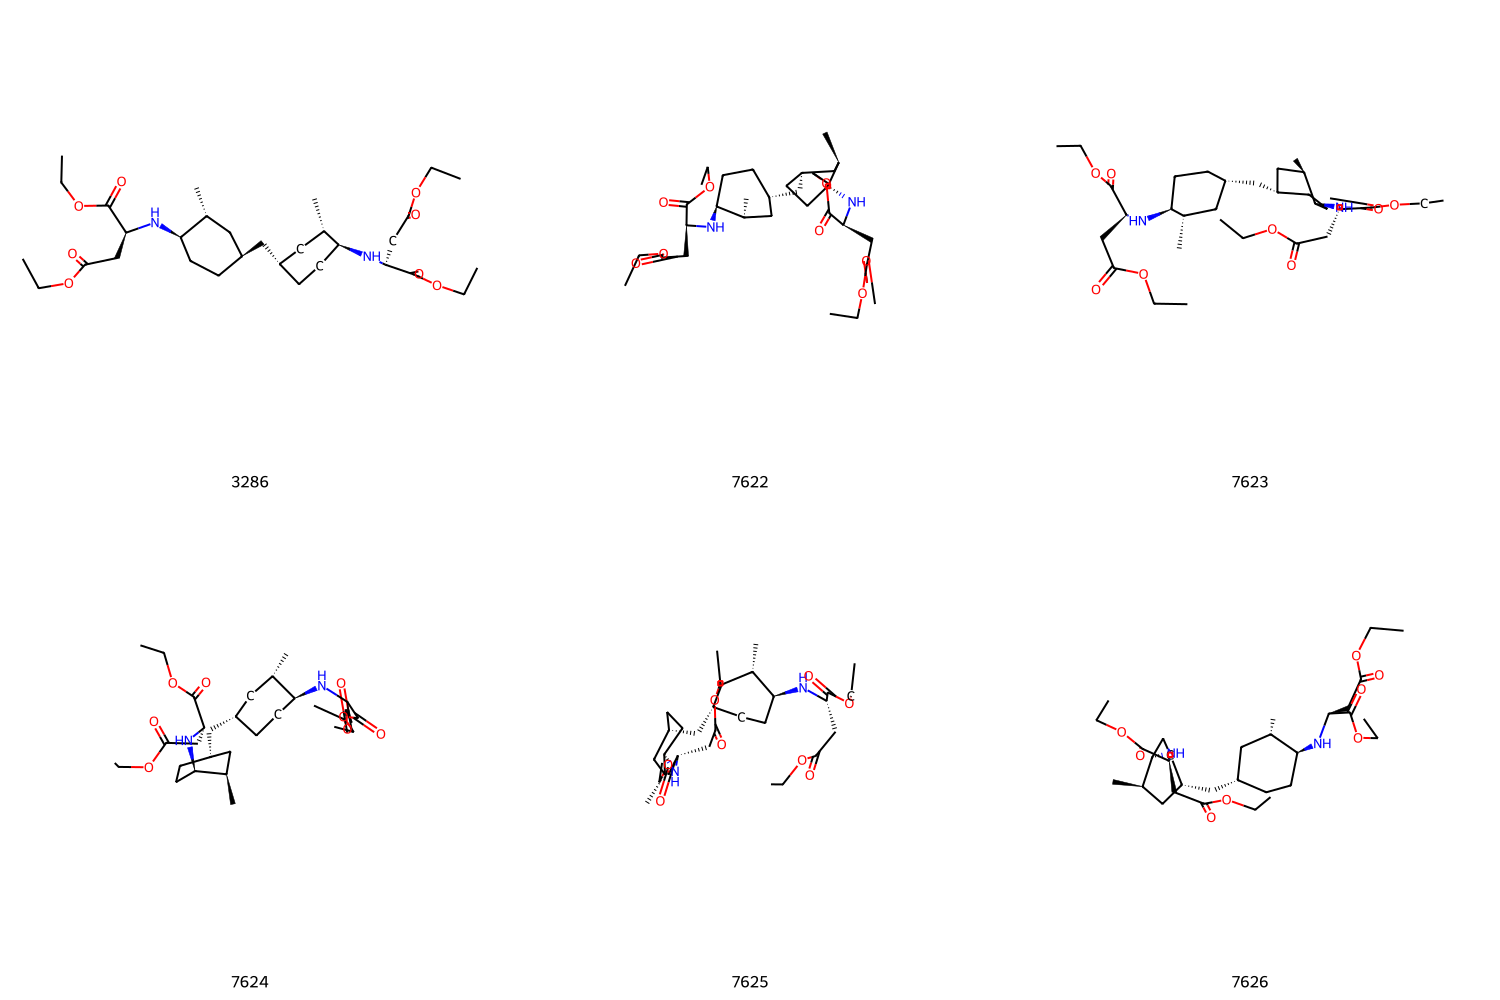

In [20]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(500,500),legends=[str(c) for c in confids])

In [22]:
ref_mol = mols[0]
for mol in mols[1:]:
    rmsd = Chem.rdMolAlign.AlignMol(mol,ref_mol)
    print(rmsd)

4.303306274543526
3.266558587483702
3.5342693361955426
4.554482981716734
3.73940330446859
